In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy
#from tqdm import tqdm
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


## prepare data

In [2]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

del train 

X_train = X_train / 255.0
test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

zoom_facor=2
imsize=X_train.shape[1]

X_trainZoom=np.zeros((X_train.shape[0],imsize*zoom_facor,imsize*zoom_facor,1))
for image_id in (range(X_train.shape[0])):
    X_trainZoom[image_id,:,:,0]=scipy.ndimage.zoom(X_train[image_id,:,:,0], zoom_facor, order=1)

testZoom=np.zeros((test.shape[0],imsize*zoom_facor,imsize*zoom_facor,1))
for image_id in (range(test.shape[0])):
    testZoom[image_id,:,:,0]=scipy.ndimage.zoom(test[image_id,:,:,0], zoom_facor, order=1)


In [3]:
# 'new_lables' splits the '4' digit to two kinds of 4's (adding a category)
Y_train = pd.read_csv("new_lables.csv")
Y_train=Y_train["Lable"]

#print(type(Y_train))
#print(Y_train.shape)
#Y_train.head(50)
#print(Y_train.value_counts())

Y_train = to_categorical(Y_train, num_classes = 11)

In [4]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_trainZoom, Y_train, test_size = 0.2, random_state=random_seed)
del X_trainZoom
del test

In [5]:
# Visualize data:

#g = plt.imshow(X_train[10][:,:,0])
#print(Y_train[0:50,0:44])



## Build and traing model

In [6]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [7]:
X_input=Input(shape=(56, 56, 1), name='Input_Layer')

X = Conv2D(32, (5, 5), strides = (1, 1), padding='same', name = 'conv1')(X_input)
#X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b1')(X)
X = Dropout(0.25, name='drop1')(X)
X = Activation('relu', name='activate1')(X)
X = MaxPooling2D(pool_size=2, strides=2, name='maxpool1')(X)

X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', name = 'conv2')(X)
#X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b2')(X)
X = Dropout(0.25, name='drop2')(X)
X = Activation('relu', name='activate2')(X)
X = MaxPooling2D(pool_size=2, strides=2, name='maxpool2')(X)

X = Conv2D(128, (3, 3), strides = (1, 1), padding='same', name = 'conv3')(X)
#X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b3')(X)
X = Dropout(0.25, name='drop3')(X)
X = Activation('relu', name='activate3')(X)
X = MaxPooling2D(pool_size=2, strides=2, name='maxpool3')(X)

X = Conv2D(256, (3, 3), strides = (1, 1), padding='same', name = 'conv4')(X)
#X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b4')(X)
X = Dropout(0.25, name='drop4')(X)
X = Activation('relu', name='activate4')(X)
X = MaxPooling2D(pool_size=2, strides=2, name='maxpool4')(X)

X = Conv2D(512, (3, 3), strides = (1, 1), padding='same', name = 'conv5')(X)
#X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b5')(X)
X = Dropout(0.25, name='drop5')(X)
X = Activation('relu', name='activate5')(X)
X = MaxPooling2D(pool_size=3, strides=3, name='maxpool5')(X)

X = Flatten(name='flatten_to_dense')(X)
#X = Dense(512,activation='relu',name='dense1')(X)
#X = Dropout(0.5, name='drop_dense1')(X)
X = Dense(256,activation='relu',name='dense2')(X)
X = Dropout(0.5, name='drop_dense2')(X)
X = Dense(11,activation='softmax',name='output')(X)

model = Model(inputs=X_input, outputs=X)

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=2, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
#model.summary()

In [9]:
epochs = 100 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#                    validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/100
390/390 [==============================] - 25s 65ms/step - loss: 0.3326 - acc: 0.9002 - val_loss: 0.2062 - val_acc: 0.9801
Epoch 2/100
390/390 [==============================] - 25s 64ms/step - loss: 0.1288 - acc: 0.9629 - val_loss: 0.1569 - val_acc: 0.9850
Epoch 3/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0955 - acc: 0.9725 - val_loss: 0.0993 - val_acc: 0.9881
Epoch 4/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0822 - acc: 0.9766 - val_loss: 0.1024 - val_acc: 0.9867
Epoch 5/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0747 - acc: 0.9795 - val_loss: 0.0897 - val_acc: 0.9886
Epoch 6/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0683 - acc: 0.9804 - val_loss: 0.0454 - val_acc: 0.9904
Epoch 7/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0603 - acc: 0.9827 - val_loss: 0.0447 - val_acc: 0.9919
Epoch 8/100
390/390 [==============================] - 

390/390 [==============================] - 25s 64ms/step - loss: 0.0146 - acc: 0.9958 - val_loss: 0.0241 - val_acc: 0.9946
Epoch 55/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0136 - acc: 0.9961 - val_loss: 0.0237 - val_acc: 0.9946
Epoch 56/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0121 - acc: 0.9962 - val_loss: 0.0238 - val_acc: 0.9948
Epoch 57/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0135 - acc: 0.9958 - val_loss: 0.0240 - val_acc: 0.9946
Epoch 58/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0146 - acc: 0.9957 - val_loss: 0.0240 - val_acc: 0.9945
Epoch 59/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0131 - acc: 0.9960 - val_loss: 0.0242 - val_acc: 0.9943
Epoch 60/100
390/390 [==============================] - 25s 64ms/step - loss: 0.0135 - acc: 0.9958 - val_loss: 0.0240 - val_acc: 0.9944
Epoch 61/100
390/390 [==============================] - 25s 6

/usr/lib/python2.7/dist-packages/matplotlib/artist.py:210: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


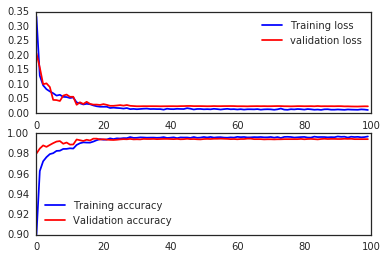

In [10]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [11]:
# Save model and hostory:
basename="zoom_newlables_5CNN_1Dense_"+str(epochs)+"epochs"
historydata = pd.DataFrame.from_dict(history.history)
historydata.to_csv(basename+"-history.csv")
#model.save(basename+"-model.h5")

# serialize model to JSON
model_json = model.to_json()
with open(basename+"-model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(basename+"-wights.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
# predict results

# THIS HAS POTENTIAL ERROR - THE '4' CATEGORIES AREN'T MERGED!!!!!!!!!!!!!

#results = model.predict(testZoom)

# select the indix with the maximum probability
#results = np.argmax(results,axis = 1)

#results = pd.Series(results,name="Label")
#results[results==10]=4

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv(basename+"-submission.csv",index=False)

## Next few of cells are for analyzing data

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(11))

In [ ]:
Y_pred_classes[Y_pred_classes==10]=4
Y_true[Y_true==10]=4
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [ ]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((56,56)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)